# COMPARATIVE ANALYSIS: LINEAR REGRESSION VS. MULTI-LAYER PERCEPTRON (MLP)
**Author:** Xuan Thanh Phong Nguyen

### 1. Import Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### 2. Prepare Model MLP

In [8]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.layer1 = nn.Linear(1,64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64,32)
        self.output = nn.Linear(32,1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

class PytorchMLPWrapper:
    def __init__(self, learning_rate = 0.0001, epochs = 1000):
        self.model = MLPNet()
        self.criterion = nn.MSELoss()
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.scaler = StandardScaler()
        self.optimizer = optim.Adam(self.model.parameters(), lr = self.learning_rate)
        
    def fit( self, X, y):
        X_scaled = self.scaler.fit_transform(X)

        inputs = torch.tensor(X_scaled, dtype= torch.float32)
        target = torch.tensor(y, dtype = torch.float32)
        
        self.model.train()  
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, target)

            loss.backward()
            self.optimizer.step()
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_scaled = self.scaler.transform(X)
            inputs = torch.tensor(X_scaled, dtype= torch.float32)
            predictions = self.model(inputs)
        return predictions.numpy()


### 3. Generate Data

In [9]:
def generate_data(n_samples, noise_level, random_seed = 42):
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, 1) * 10

    noise = np.random.randn(n_samples,1) * noise_level
    y = 3 * X + 2 + noise
    return X.reshape(-1,1), y.reshape(-1,1)

### 4. Explore

In [10]:
def run_all_experiments():
    sizes = [20, 50, 100, 500 , 1000]
    nosie_levels = [0, 2, 5, 10, 20]
    mse_noise_lr, mse_noise_torch = [], []
    mse_size_lr, mse_size_torch = [], []
    for n in sizes:
        X, y = generate_data(n_samples = n, noise_level= 2) 

        lr = LinearRegression()
        lr.fit(X,y)
        mse_size_lr.append(mean_squared_error(y, lr.predict(X)))

        pt = PytorchMLPWrapper(epochs = 2000)
        pt.fit(X,y)
        mse_size_torch.append(mean_squared_error(y, pt.predict(X)))

    for noise in nosie_levels:
        X, y = generate_data(n_samples=200, noise_level= noise)        
        
        lr = LinearRegression()
        lr.fit(X,y)
        mse_noise_lr.append(mean_squared_error(y, lr.predict(X)))

        pt = PytorchMLPWrapper(epochs = 1000)
        pt.fit(X,y)
        mse_noise_torch.append(mean_squared_error(y, pt.predict(X)))

    
    X, y = generate_data(10000, noise_level = 2.0)    
    s = time.time()
    lr = LinearRegression()
    lr.fit(X,y)
    lr_time = time.time() - s

    s = time.time()
    pt = PytorchMLPWrapper(epochs= 200).fit(X,y)
    pt_time = time.time() - s

    return (sizes,mse_size_lr, mse_size_torch),(nosie_levels,mse_noise_lr, mse_noise_torch),(lr_time, pt_time)   


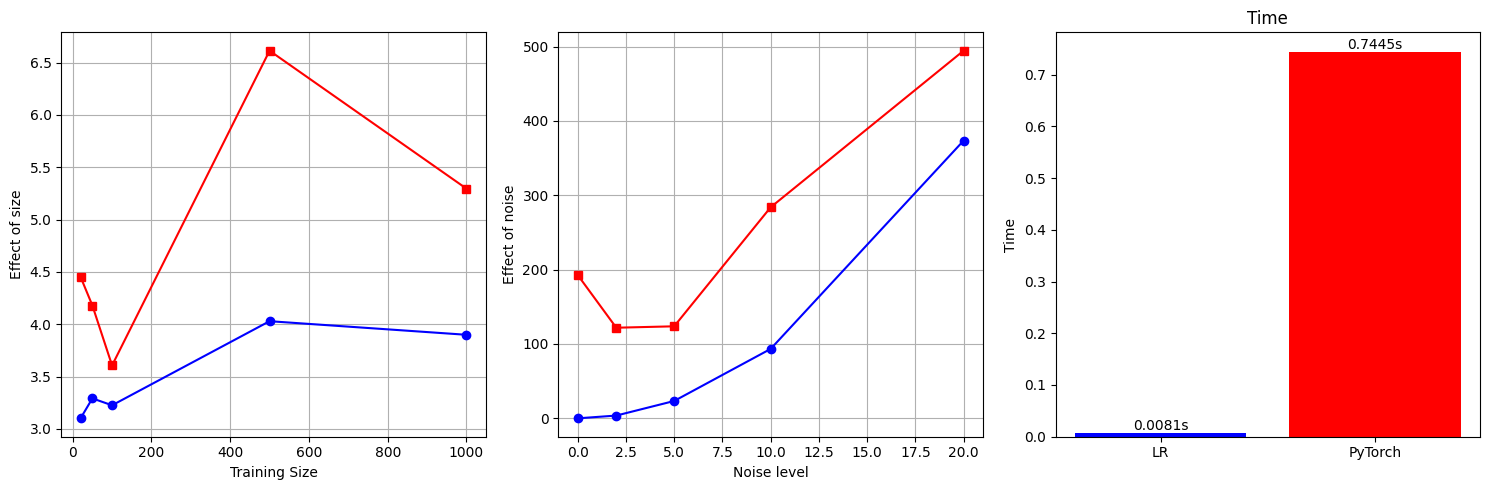

In [15]:
if __name__ == "__main__":
    res_size, res_nosie, res_time = run_all_experiments()

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.plot(res_size[0], res_size[1],'o-', label = "Linear Regression" , color = 'blue')
    plt.plot(res_size[0], res_size[2],'s-', label = "Pytorch MLP" , color = 'red')
    plt.xlabel("Training Size")
    plt.ylabel("Effect of size")
    plt.grid()

    plt.subplot(1,3,2)
    plt.plot(res_nosie[0], res_nosie[1],'o-', label = "Linear Regression" , color = 'blue')
    plt.plot(res_nosie[0], res_nosie[2],'s-', label = "Pytorch MLP" , color = 'red')
    plt.xlabel("Noise level")
    plt.ylabel("Effect of noise")
    plt.grid()

    plt.subplot(1,3,3)
    plt.bar(['LR', 'PyTorch'], [res_time[0], res_time[1]], color = ['blue', 'red'])
    plt.title('Time')
    plt.ylabel("Time")
    plt.text(0, res_time[0], f"{res_time[0]:.4f}s" , ha = 'center', va = 'bottom')
    plt.text(1, res_time[1], f"{res_time[1]:.4f}s" , ha = 'center', va = 'bottom')
    
    plt.tight_layout()
    plt.show()  

Research Conclusion:

Efficiency: Linear Regression is significantly faster (>100x) and more efficient for linear datasets.

Stability: MLP shows high variance and instability across different training sizes due to its complex optimization landscape.

Robustness: MLP tends to overfit noise significantly more than Linear Regression as noise levels increase.

Recommendation: For linear problems, simple models like Linear Regression should always be the baseline choice before considering complex Deep Learning architectures.